In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pdb

In [2]:
data_dir = f'/lab_data/behrmannlab/claire/pepdoc/results_ex1' #read in the file; first value is the file name
bin_size = 5 #20 ms bins (EACH BIN IS 4 MS SO 5 ROWS ARE 20 MS)
# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data

#d_channels
dorsal_channels = [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 110, 109, 118, 131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127] # a list of channels
dorsal_columns  =[f'E{ii}' for ii in dorsal_channels] #convert channels into the same format as the columns

#v_channels
ventral_channels = [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134, 169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174] # a list of channels
ventral_columns  =[f'E{ii}' for ii in ventral_channels] #convert channels into the same format as the columns

#c_channels
control_channels =  [11, 12, 18, 19, 20, 21, 25, 26, 27, 32, 33, 34, 37, 38]
control_columns  =[f'E{ii}' for ii in control_channels] #convert channels into the same format as the columns

# comments
# dorsal channels: LEFT [77, 78, 79, 80, 86/P3, 87, 88, 89, 98, 99, 100, 110, 109, 118] RIGHT [131, 143, 154, 163, 130, 142, 153, 162/P4, 129, 141, 152, 128, 140, 127]
# ventral channels: LEFT [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134] RIGHT [169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174]
# control channels: 11, 12, 18, 19 20, 21, 25, 26, 27, 32, 33, 34, 37, 38

svm_test_size = .4
svm_splits = 20
sss = StratifiedShuffleSplit(n_splits=svm_splits, test_size=svm_test_size)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

#d_cols = [f'E{ii}' for ii in d_channels]
#v_cols = [f'E{ii}' for ii in v_channels]

In [3]:
'''
Load All Subjects Data
'''
all_subs = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
all_sub_data = []
all_sub_dorsal =[]
all_sub_ventral =[]
all_sub_control = []

for nSubject in all_subs: #loop through subs
    all_data =[]
    all_ventral =[]
    all_dorsal =[]
    all_control = []
    for category in categories: #loop through categories
        for nn in range(1,6): #loop through exemplars in categories
           
            curr_df = pd.read_csv(f'/{data_dir}/{nSubject}/{category}s/{category}{nn}.tsv' , sep='\t')#read in the file; first value is the file name
            curr_df = curr_df.T #use pandas to transpose data
            curr_df.columns = curr_df.iloc[0] #set the column names to the first row
            curr_df = curr_df.drop(curr_df.index[0]) #drop the first row
            curr_df = curr_df.astype(float) #convert to float

            bin_data = curr_df.rolling(bin_size).mean() #rolling avg given the bin size
            
            bin_data = bin_data.dropna() #drop missing values
            bin_data = bin_data.reset_index() #reset the index of the dataframe
            
            all_channel_data = bin_data.drop(columns = ['index']) #drop columns that are not channels

            dorsal_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in dorsal_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    dorsal_df[ii] = all_channel_data[ii] #if it does add it the empty one

            ventral_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in ventral_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    ventral_df[ii] = all_channel_data[ii] #if it does add it the empty one


            control_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in control_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    control_df[ii] = all_channel_data[ii] #if it does add it the empty one

            all_data.append(all_channel_data.to_numpy())
            all_dorsal.append(dorsal_df.to_numpy())
            all_ventral.append(ventral_df.to_numpy())
            all_control.append(control_df.to_numpy())
            #all_subs.append(nSubject.split('_')[0])
            
          
    all_data = np.asanyarray(all_data) # the error "ValueError: could not broadcast input array from shape (138,240) into shape (138,)" is because the data is not the same length for all participants/error in adding participants.
    all_dorsal = np.asanyarray(all_dorsal)
    all_ventral = np.asanyarray(all_ventral)  
    all_control = np.asanyarray(all_control)

    all_sub_data.append(all_data) #add the subject to the list of subjects
    all_sub_dorsal.append(all_dorsal)
    all_sub_ventral.append(all_ventral)
    all_sub_control.append(all_control)

In [4]:
"""
Decode from all channels
"""
all_sub_decode = []

for sub_decode in all_sub_data: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    cat_decode = []
    for time in range(0, sub_decode.shape[1]):
        
        X = sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index] #
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        cat_decode.append(np.mean(temp_acc))

    cat_decode = np.asanyarray(cat_decode)
    all_sub_decode.append(cat_decode)

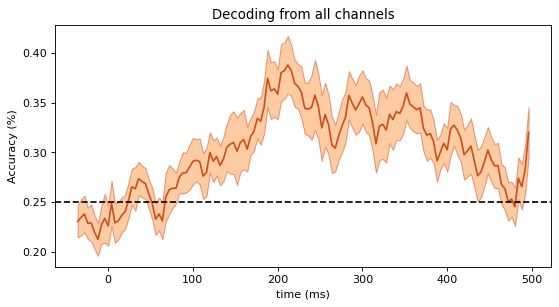

In [13]:
'''
Plot decode from all channels
'''

mean_decode = np.mean(all_sub_decode, axis=0)
decode_std = np.std(all_sub_decode, axis=0) 
std_error = np.std(all_sub_decode, ddof=1, axis =0) / np.sqrt(len(all_sub_decode))
#print(std_error)

#plt.plot(np.mean(all_sub_decode, axis=0))
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)

timepoints = list(range(-36, 500, 4)) #134 20 ms bins
#timepoints = list(range(-26, 450, 4)) #119 or 80 ms bins
#timepoints = list(range(-52, 500, 4)) # or 4 ms bins
#timepoints = list(range(-1, 275, 2)) # or 4 ms bins

#plt.errorbar(timepoints, mean_decode, yerr=std_error, fmt='o')
plt.plot(timepoints, mean_decode, color='#CC4F1B') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
#plt.axhline(y=0.2215, color='k', linestyle='--')
plt.fill_between(timepoints, mean_decode-std_error, mean_decode+std_error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from all channels')
plt.show()




In [7]:
'''
Decode from all dorsal channels
'''

d_sub_decode = []

for dorsal_sub_decode in all_sub_dorsal: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    dorsal_cat_decode = []
    for time in range(0, dorsal_sub_decode.shape[1]):
        X = dorsal_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index] #
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        dorsal_cat_decode.append(np.mean(temp_acc))

    dorsal_cat_decode = np.asanyarray(dorsal_cat_decode)
    d_sub_decode.append(dorsal_cat_decode)

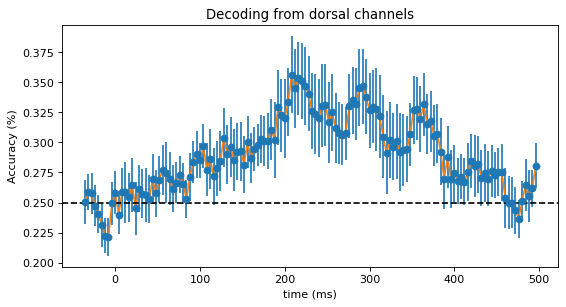

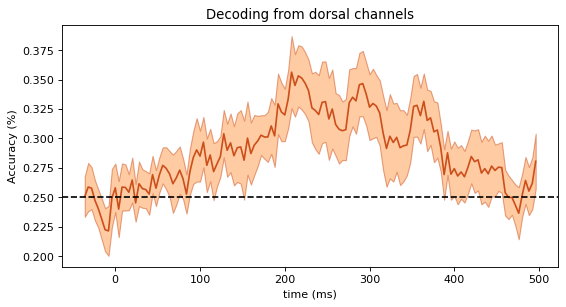

In [11]:
'''
Plot decode from all dorsal channels
'''

mean_decode_dorsal = np.mean(d_sub_decode, axis=0)
decode_std_dorsal = np.std(d_sub_decode, axis=0) 
std_error_dorsal = np.std(d_sub_decode, ddof=1, axis = 0) / np.sqrt(len(d_sub_decode))
#print(std_error_dorsal)

#plt.plot(np.mean(all_sub_decode, axis=0))
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)

dorsal_timepoints = list(range(-36, 500, 4))

plt.errorbar(dorsal_timepoints, mean_decode_dorsal, yerr=std_error_dorsal, fmt='o')
plt.plot(dorsal_timepoints, mean_decode_dorsal)
#plt.plot(mean_decode_dorsal) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from dorsal channels')
plt.show()

## Ribbon plot #############################################################################################
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)
dorsal_timepoints = list(range(-36, 500, 4))
plt.plot(dorsal_timepoints, mean_decode_dorsal, color='#CC4F1B') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.fill_between(dorsal_timepoints, mean_decode_dorsal-std_error, mean_decode_dorsal+std_error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from dorsal channels')
plt.show()

In [10]:
'''
Decode from all ventral channels
'''

v_sub_decode = []

for ventral_sub_decode in all_sub_ventral: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    ventral_cat_decode = []
    for time in range(0, ventral_sub_decode.shape[1]):
        X = ventral_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index] #
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        ventral_cat_decode.append(np.mean(temp_acc))

    ventral_cat_decode = np.asanyarray(ventral_cat_decode)
    v_sub_decode.append(ventral_cat_decode)

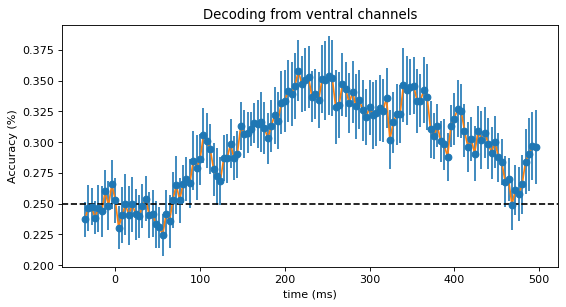

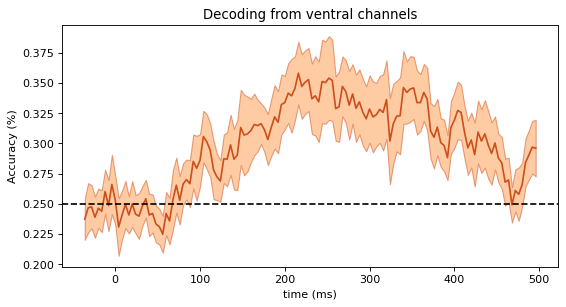

In [12]:
'''
Plot decode from all ventral channels
'''

mean_decode_ventral = np.mean(v_sub_decode, axis=0)
decode_std_ventral = np.std(v_sub_decode, axis=0) 
std_error_ventral = np.std(v_sub_decode, ddof=1, axis = 0) / np.sqrt(len(v_sub_decode))
#print(std_error_ventral)

#plt.plot(np.mean(all_sub_decode, axis=0))
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)

timepoints_ventral = list(range(-36, 500, 4))

plt.errorbar(timepoints_ventral, mean_decode_ventral, yerr=std_error_ventral, fmt='o')
plt.plot(timepoints_ventral, mean_decode_ventral) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from ventral channels')
plt.show()

## Ribbon plot #############################################################################################
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)
timepoints_ventral = list(range(-36, 500, 4))
plt.plot(timepoints_ventral, mean_decode_ventral, color='#CC4F1B') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.fill_between(timepoints_ventral, mean_decode_ventral-std_error, mean_decode_ventral+std_error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from ventral channels')
plt.show()

In [ ]:
'''PLOT DECODING RESULTS - SINGLE SUBJECTS'''

iSub_plot = []
n = 0
for plot_iSub in all_sub_decode:
    print(n)
    mean_decode = np.mean(all_sub_decode, axis=0)
    decode_std = np.std(all_sub_decode, axis=0) 
    std_error = np.std(all_sub_decode, ddof=1) / np.sqrt(len(all_sub_decode))

    
    

    timepoints = list(range(-36, 500, 4))
    plt.plot(timepoints, plot_iSub) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    #plt.errorbar(timepoints, mean_decode, yerr=std_error, fmt='o')

    plt.axhline(y=0.25, color='k', linestyle='--')
    plt.xlabel('time (ms)')
    plt.ylabel('Accuracy (%)')
    plt.title('Decoding from all channels')
    
    
    
    figure(figsize=(8, 4), dpi=80)
    plt.show()
    n += 1

    

In [13]:
'''
Decode from all control channels
'''

c_sub_decode = []

for control_sub_decode in all_sub_control: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    control_cat_decode = []
    for time in range(0, control_sub_decode.shape[1]):
        X = control_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index] #
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        control_cat_decode.append(np.mean(temp_acc))

    control_cat_decode = np.asanyarray(control_cat_decode)
    c_sub_decode.append(control_cat_decode)

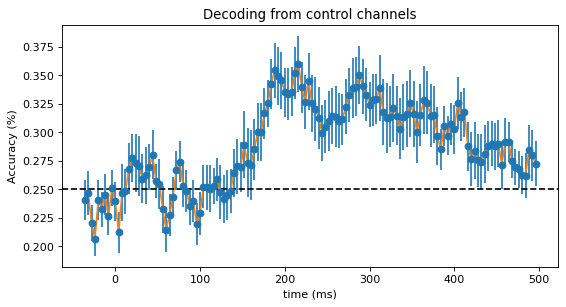

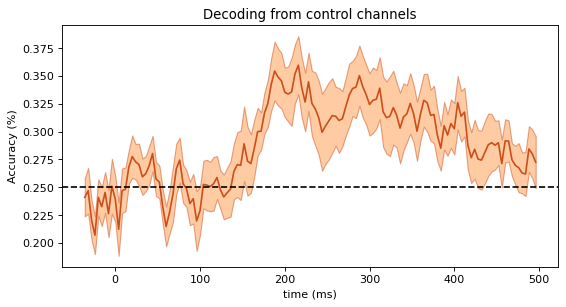

In [18]:
'''
Plot decode from all control channels
'''

mean_decode_control = np.mean(c_sub_decode, axis=0)
decode_std_control = np.std(c_sub_decode, axis=0) 
std_error_control = np.std(c_sub_decode, ddof=1, axis = 0) / np.sqrt(len(c_sub_decode))
#print(std_error_control)

#plt.plot(np.mean(all_sub_decode, axis=0))
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)

timepoints_control = list(range(-36, 500, 4))

plt.errorbar(timepoints_control, mean_decode_control, yerr=std_error_control, fmt='o')
plt.plot(timepoints_control, mean_decode_control) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from control channels')
plt.show()


## Ribbon plot #############################################################################################
from matplotlib.pyplot import figure
figure(figsize=(8, 4), dpi=80)
timepoints_control = list(range(-36, 500, 4))
plt.plot(timepoints_control, mean_decode_control, color='#CC4F1B') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.fill_between(timepoints_control, mean_decode_control-std_error, mean_decode_control+std_error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from control channels')
plt.show()

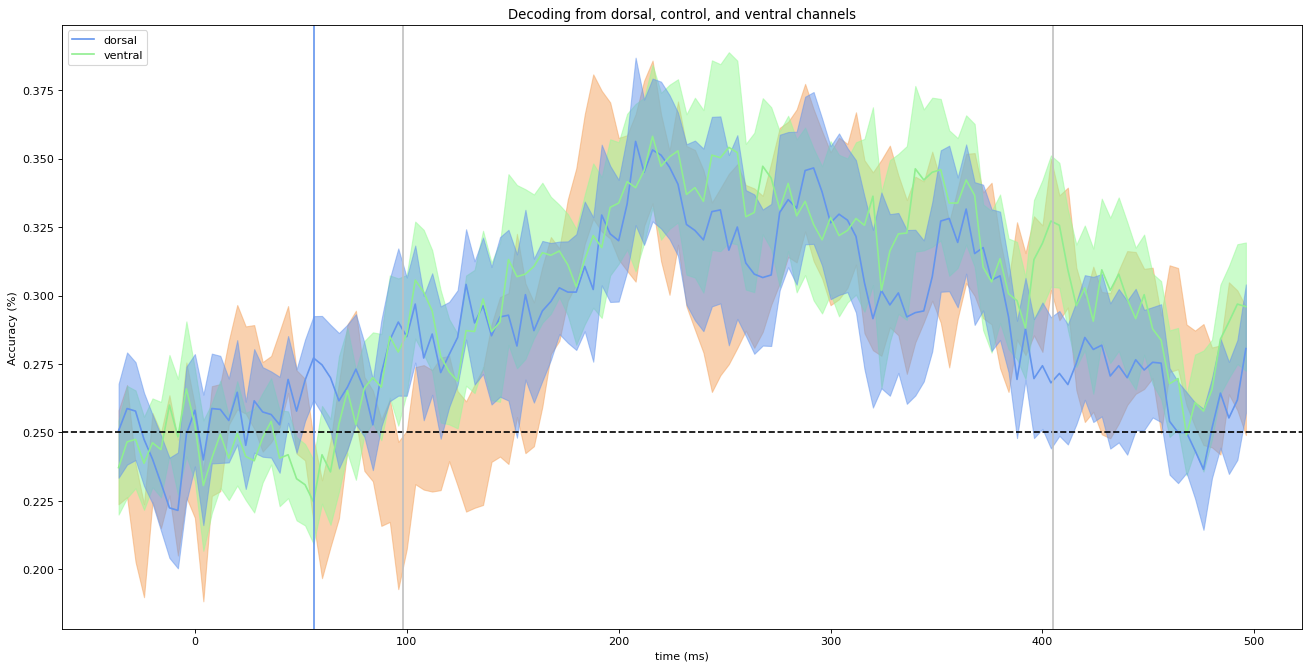

In [85]:
"""
Plot overlay of dorsal, ventral, and control channels
"""
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)


#Plot dorsal and all channels
#plt.errorbar(timepoints_control, mean_decode_control, yerr=std_error_control, fmt='o')
#plt.errorbar(timepoints_ventral, mean_decode_ventral, yerr=std_error_ventral, fmt='o')
#plt.errorbar(dorsal_timepoints, mean_decode_dorsal, yerr=std_error_dorsal, fmt='o')

plt.plot(dorsal_timepoints, mean_decode_dorsal, color = 'cornflowerblue', label='dorsal') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
#plt.plot(timepoints_control, mean_decode_control, color = 'sandybrown', label='control')
plt.plot(timepoints_ventral, mean_decode_ventral, color = 'lightgreen', label='ventral')
plt.legend(loc='upper left')

plt.axhline(y=0.25, color='k', linestyle='--')
plt.axvline(x=56, color='cornflowerblue', linestyle='-')
plt.axvline(x=98, color='silver', linestyle='-')
plt.axvline(x=405, color='silver', linestyle='-')



plt.fill_between(timepoints_control, mean_decode_control-std_error, mean_decode_control+std_error,
    alpha=0.5, edgecolor='sandybrown', facecolor='sandybrown') # comment out if you want to remove the error bars
plt.fill_between(timepoints_ventral, mean_decode_ventral-std_error, mean_decode_ventral+std_error,
    alpha=0.5, edgecolor='palegreen', facecolor='palegreen')
plt.fill_between(dorsal_timepoints, mean_decode_dorsal-std_error, mean_decode_dorsal+std_error,
    alpha=0.5, edgecolor='cornflowerblue', facecolor='cornflowerblue')


plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')
plt.title('Decoding from dorsal, control, and ventral channels')
plt.show()


#see 60 ms for dorsal peak and 100 ms for ventral peak

In [ ]:
# comments
# dorsal channels: LEFT [77, 78, 79, 80, 86/P3, 87, 88, 89, 98, 99, 100, 110, 109, 118] RIGHT [131, 143, 154, 163, 130, 142, 153, 162/P4, 129, 141, 152, 128, 140, 127]
# ventral channels: LEFT [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134] RIGHT [169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174]
# control channels: 11, 12, 18, 19 20, 21, 25, 26, 27, 32, 33, 34, 37, 38